In [1]:
import numpy as np
import torch

In [2]:
from torch.utils.data import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONNECTION = torch.tensor([[0,0,0,1,1,2,2,3,3,4,5,5,5,6,6,7,7,8,9,9,9,10,10,11,11,12,13,13,13,14,14,15,15,16,17,17,17,18,18,19,19,20],
                           [1,5,17,0,2,1,3,2,4,3,0,9,6,5,7,8,6,7,5,10,13,9,11,10,12,11,9,14,17,13,15,14,16,15,0,13,18,17,19,18,20,19]], dtype=torch.long)
LR = 0.003
BATCH = 2048
LATENT_DIM = 4

class TripletGestureDataset(Dataset):

    def __init__(self, data: np.ndarray, labels: np.ndarray):
        """
        初始化函数。
        :param data: 形状为(n, 21, 3)的numpy数组，n为样本数量。
        :param labels: 形状为(n, num_classes)的numpy数组，每个标签为one-hot编码。
        """

        # ## 数据增强
        # data = np.abs(data)
        # data = (data - np.min(data)) / (np.max(data) - np.min(data))

        ## add the two nearby length in each finger

        self.data = torch.tensor(data, dtype=torch.float32).reshape((-1, 21, 3))
        # 将one-hot编码的标签转换为类别索引
        self.labels = np.argmax(labels, axis=1)
        # 预计算每个类别的索引列表，以便快速随机选择样本
        self.indices = [np.where(self.labels == i)[0] for i in np.unique(self.labels)]

    def __len__(self):
        """
        返回数据集中的样本数。
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        从数据集中获取一个样本及其正例和负例。
        :param idx: 锚点样本的索引。
        """
        anchor = self.data[idx]
        label = self.labels[idx]

        # 选择正例，即同一类别中的另一个样本
        positive_index = idx
        while positive_index == idx:  # 确保正例不是锚点本身
            positive_index = np.random.choice(self.indices[label])
        positive = self.data[positive_index]

        # 选择负例，即不同类别的样本
        negative_label = np.random.choice([l for l in range(len(self.indices)) if l != label])
        negative_index = np.random.choice(self.indices[negative_label])
        negative = self.data[negative_index]

        return anchor, positive, negative, label

    def get_input_dim(self):
        return 3

In [3]:
from torch.utils.data import DataLoader

## load the data
raw_data = np.load('./dataset/8class_dataset_100k.npz')
train_data, train_label, test_data, test_label = raw_data['train_data'], raw_data['train_label'], raw_data['test_data'], \
    raw_data['test_label']
train_dataset = TripletGestureDataset(train_data, train_label)
test_dataset = TripletGestureDataset(test_data, test_label)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

data_dim = train_dataset.get_input_dim()
print(data_dim)

3


In [4]:
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, Sequential, global_mean_pool


# 初始化模型, 损失函数, 和优化器
class TripletAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(TripletAutoencoder, self).__init__()
        self.encoder = Sequential(
            input_args = 'x, edge_index',
            modules = (
                (GCNConv(input_dim, 64),'x, edge_index -> x'),
                nn.ReLU(True),
                (GCNConv(64, 32),'x, edge_index -> x'),
                nn.ReLU(True),
                (GCNConv(32, 16),'x, edge_index -> x'),
                lambda x : torch.reshape(x, (-1, 16*21)),
                #(lambda x : global_mean_pool(x, torch.tensor([BATCH-1], dtype=torch.int64).to(device)), 'x -> x'),
                nn.Linear(16*21, 64),
                nn.Dropout(),
                nn.ReLU(True),
                nn.Linear(64, latent_dim)
            )
        )
        self.decoder = Sequential(
            input_args = 'x, edge_index',
            modules = (
                (nn.Linear(latent_dim, latent_dim*21), 'x -> x'),
                (lambda x : torch.reshape(x, (-1, 21, latent_dim)), 'x -> x'),
                (GCNConv(latent_dim, 32), 'x, edge_index -> x'),
                nn.ReLU(True),
                (GCNConv(32, 64), 'x, edge_index -> x'),
                nn.ReLU(True),
                (GCNConv(64, input_dim), 'x, edge_index -> x'),
        )
        )

    def forward(self, x):
        encoded = self.encoder(x, CONNECTION.to(device))
        decoded = self.decoder(encoded, CONNECTION.to(device))
        return encoded, decoded




model = TripletAutoencoder(input_dim=data_dim, latent_dim=LATENT_DIM).to(device)

reconstruction_loss = nn.MSELoss()
triplet_loss = nn.TripletMarginLoss(margin=1.0)

optimizer = optim.Adam(model.parameters(), lr=LR)

In [5]:
from tqdm.notebook import tqdm

model.train()

num_epochs = 80

for epoch in range(num_epochs):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    total_loss = 0
    total_r_loss = 0
    total_t_loss = 0

    for anchors, positives, negatives, _ in progress_bar:
        # 将数据移动到GPU上
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)

        # 获取编码和解码的输出
        anchor_encoded, anchor_decoded = model(anchors)
        positive_encoded, _ = model(positives)
        negative_encoded, _ = model(negatives)
        # 计算重构损失和Triplet损失
        r_loss = reconstruction_loss(anchor_decoded, anchors)
        t_loss = triplet_loss(anchor_encoded, positive_encoded, negative_encoded)
        loss = r_loss + t_loss
        #loss = t_loss
        # loss = r_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 累计损失用于计算平均损失
        total_loss += loss.item()
        total_r_loss += r_loss.item()
        total_t_loss += t_loss.item()

        progress_bar.desc = f"Epoch {epoch + 1}/{num_epochs}"
        progress_bar.set_postfix({
            'total_loss': f'{total_loss / (progress_bar.n + 1):.4f}',
            'recon_loss': f'{total_r_loss / (progress_bar.n + 1):.4f}',
            'triplet_loss': f'{total_t_loss / (progress_bar.n + 1):.4f}'
        })

Epoch 1/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 26/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 27/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 28/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 29/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 30/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 31/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 32/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 33/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 34/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 35/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 36/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 37/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 38/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 39/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 40/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 41/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 42/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 43/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 44/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 45/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 46/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 47/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 48/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 49/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 50/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 51/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 52/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 53/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 54/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 55/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 56/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 57/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 58/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 59/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 60/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 61/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 62/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 63/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 64/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 65/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 66/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 67/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 68/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 69/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 70/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 71/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 72/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 73/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 74/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 75/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 76/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 77/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 78/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 79/80:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 80/80:   0%|          | 0/49 [00:00<?, ?it/s]

In [6]:
## run the test samples through the encoder

model.eval()

test_labels = []
test_latent = []

for inputs, _, _, labels in test_loader:
    inputs = inputs.to(device)
    inputs = inputs.view(-1, data_dim)
    outputs = model.encoder(inputs, CONNECTION.to(device))
    test_latent.append(outputs.cpu().detach().numpy())
    test_labels.append(labels.cpu().detach().numpy())

test_latent = np.concatenate(test_latent, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

print(test_latent.shape, test_labels.shape)

(50000, 4) (50000,)


In [7]:
## calculate the centroid of each class

centroids = np.zeros((11, LATENT_DIM))
for i in range(11):
    idx = test_labels == i
    centroids[i] = np.mean(test_latent[idx], axis=0)

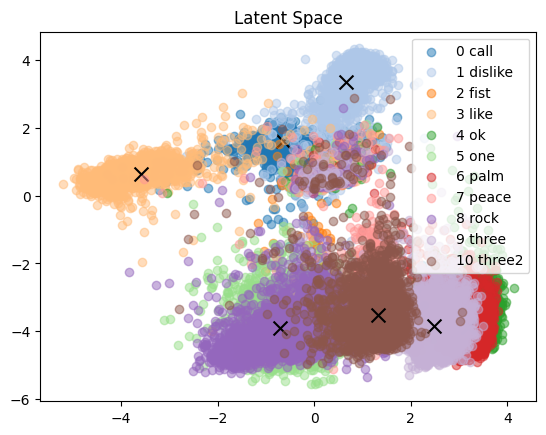

In [8]:
## plot the latent space
import matplotlib
import matplotlib.pyplot as plt

labels = np.unique(test_labels)
label_map = {
    0: 'call',
    1: 'dislike',
    2: 'fist',
    3: 'like',
    4: 'ok',
    5: 'one',
    6: 'palm',
    7: 'peace',
    8: 'rock',
    9: 'three',
    10: 'three2',
}

fig, ax = plt.subplots()

ax.set_title('Latent Space')

for i, label in enumerate(labels):
    idx = test_labels == label

    ax.scatter(test_latent[idx, 0],
               test_latent[idx, 1],
               c=np.array(matplotlib.colormaps['tab20'].colors[i]).reshape(1, -1),
               label=f"{label} {label_map[label]}",
               alpha=0.5)

    ax.scatter(centroids[i, 0], centroids[i, 1], c='black', marker='x', s=100)

ax.legend()
plt.show()

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=11, random_state=0).fit(test_latent)

# Predict the cluster IDs for each data point
cluster_ids = kmeans.predict(test_latent)

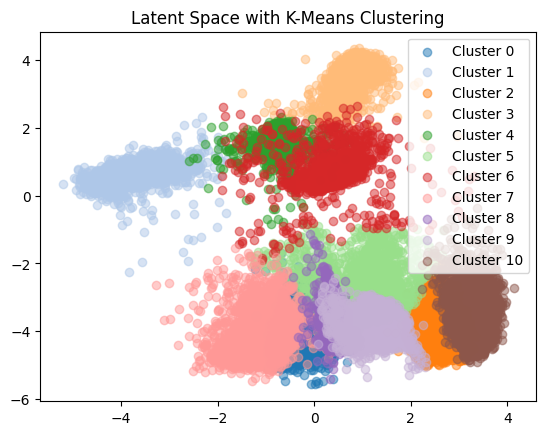

In [10]:
# Colors from a colormap
#colors = matplotlib.cm.get_cmap('tab20', 11)

fig, ax = plt.subplots()
ax.set_title('Latent Space with K-Means Clustering')

for cluster in range(11):
    idx = cluster_ids == cluster
    ax.scatter(test_latent[idx, 0],
               test_latent[idx, 1],
               c=np.array(matplotlib.colormaps['tab20'].colors[cluster]).reshape(1, -1),
               label=f"Cluster {cluster}",
               alpha=0.5)

ax.legend()
# plt.show()

In [11]:

# Calculate clustering accuracy
# We need to find the best match between cluster labels and true labels
def clustering_accuracy(true_labels, cluster_labels):
    # Confusion matrix between true labels and cluster labels
    matrix = confusion_matrix(true_labels, cluster_labels)
    # Summing the highest values in each column of the confusion matrix
    max_matches = np.sum(np.max(matrix, axis=0))
    accuracy = max_matches / len(true_labels)
    return matrix, accuracy


# Calculate and print the clustering accuracy
matrix, accuracy = clustering_accuracy(test_labels, cluster_ids)
print(f"Clustering Accuracy: {accuracy:.4f}")
# print("Confusion Matrix:")
# print(matrix)

Clustering Accuracy: 0.7214


In [12]:
# ## save model
# torch.save(model.state_dict(), './model/triplet_autoencoder_8934.pth')
# 
# ## save the centroids
# np.save('./model/triplet_autoencoder_8934_centroids.npy', centroids)